In [ ]:
import re
import csv
import json
import gzip 
import spacy

import pandas as pd
import numpy as np
import networkx as nx

from datetime import datetime
from typing import Dict, List
from dateutil.parser import parse
from unidecode import unidecode
from collections import Counter
from tqdm.notebook import tqdm
from rapidfuzz.distance import Levenshtein
from rapidfuzz.utils import default_process
from rapidfuzz.process import cdist, extract

In [30]:
# define important variables
corp_endings = {
    'private limited', 'incorporation  inc', 'inc', 'llc', 'ltd', 'se', 'asa', 'as', 
    'gmbh', 'sas', 'llp', 's a', 'corporation', 'limited', 'corp', 'bv', 'lp', 'ab', 
    'sro', 'sp', 'spa', 'sár', 'sarl', 'ag', 'sa', 'co', 'sl', 'sàrl', 'complainant', 
    'of', 'sà rl', 'sa rl', 'a', 'plc', 'oyj', 'nv', 'akteingesellschaft', 'group', 
    'of', 'b v', 'e', 'm b', 'holdings', 'slu', 'respondent'
}

# helpful functions

def parse_date(date_strings: List[str], dayfirst) -> datetime:
    """
    Generates a date from the argument, by trying various heuristics and fixing common errors.

    Args:
        date_strings: List of candidate strings containing the desired date.
        dayfirst: Whether to use the European date format (the day first) or the American one (month first)
    
    Returns:
        A datetime object if a valid date was found.
    """
    parsed_date = None
    for _date in date_strings:
        # print(_date)
        _date = re.sub('\s+', ' ', _date.replace('，', ', ').replace(',', ' , ').replace(';', ' ; ')).strip()
        try:
            parsed_date = parse(
                _date, 
                # in some cases, the date starts with the year so the second check makes sure we
                # are not considering the year as day which would lead to errors.
                dayfirst = dayfirst and len(re.findall('[0-9]{1,4}', _date)[0]) <= 2, 
                fuzzy = True, 
                ignoretz=True
            )
            if f'{parsed_date.year}' in _date or f'{parsed_date.year}'[-2:] in _date:
                break
            else:
                parsed_date = None
        except:
            continue
    return parsed_date if parsed_date and parsed_date < datetime.now() and parsed_date.timestamp() > 0 else None


def load_gpt_pair_map(infile: str) -> Dict[str, str]: 
    """
    Given an input JSON-formatted file that maps strings together based on their semantic meaning,
    the function creates a dictionary representation for easy access.

    Args:
        infile: The path to the input file.
    
    Returns:
        A mapping of source to destination strings.
    """
    outDict = {}
    with open(infile, 'rb') as fin:
        for line in fin:
            data = json.loads(line)
            outDict[data[0]] = outDict.get(data[0], []) + [data[1]]
    return outDict

def deduplicate(names: List[str], score_cutoff = 1, refMapping: Dict[str, str] = {}) -> Dict[str, str]:
    """
    Given a list of names and a reference list, this function deduplicates all the names in the input.

    Args:
        names: The values to deduplicates
        score_cutoff: The minimum similarity between two values before merging them.
        refMapping: The reference list to be used for the mapping.
    
    Returns:
        A mapping of input-string to their deduplicated version.
    """
    names_ctr = Counter(names)
    name_process = lambda x: re.sub(
        '\s+', 
        '', 
        re.sub(
            fr" ({'|'.join(corp_endings)})$", 
            "", 
            default_process(unidecode(re.sub('(\S)[./]', r'\1',x)))
        ).strip()
    )
    mx_names = names + list(refMapping.keys())
    _names = [
        re.sub(
            # this is because some companies' names were represented as "John Doe of ACME Corporation"
            'of$', 
            '', 
            re.sub('\s+', ' ', unidecode(name))
        ).strip().rstrip(',').strip().rstrip(',').strip() for name in mx_names
    ]
    # map the names between them
    dist = cdist(
        _names, _names, 
        scorer = Levenshtein.normalized_similarity, 
        processor = name_process, 
        score_cutoff = score_cutoff, 
        workers = -1
    )

    graph_dict = refMapping.copy()
    for idx, jdx in zip(*np.nonzero(dist)):
        graph_dict[mx_names[idx]] = graph_dict.get(mx_names[idx], []) + [mx_names[jdx]]
    valsMap = {}

    # use transitive relations for deduplications
    G = nx.from_dict_of_lists(graph_dict)
    for cc in nx.connected_components(G):
        # find the name that represents the cluster best
        repr_name = re.sub(
            'of$', 
            '', 
            re.sub(
                '\s+', 
                ' ', 
                unidecode(max(cc, key = lambda x: names_ctr.get(x, 0)))
            )
        ).strip().rstrip(',').strip().rstrip(',').strip()
        if name_process(repr_name) not in corp_endings.union(['']):
            valsMap.update({val: repr_name for val in cc})
    return valsMap

In [ ]:
spacy.prefer_gpu(1)

infile = '../data/Jan2023-Aug2024-disputes.jsonl.gz'
outfile = '../data/Jan2023-Aug2024-parsed-proceedings.jsonl.gz'

entities = [
    'FILING_DATE', 'REGISTRAR_REQ_DATE', 'REGISTRAR_REQ_RESP', 'COMMENCEMENT_DATE',
    'APPT_DATE', 'PUB_DATE', 'COMPLAINANT', 'COMP_LOC', 'REPR_ORG', 'RESPONDENT',
    'RESP_LOC', 'NO_RESPONSE', 'PANELIST', 'REGISTRAR', 'TRADEMARK'
]

model_id = 'en_udrp_extractor_baseline'

nlp = spacy.load(model_id)

# load the file
df = pd.read_json(infile, lines = True)

out_arr = []

# extract the features from the proceedings
for case, doc in tqdm(zip(df.itertuples(index = False), nlp.pipe(df.text.tolist())), total = df.shape[0]):
    record = {
        'source': case.source, 'number': case.number, 'domains': case.domains, 
        'complainants': case.complainants, 'respondents': case.respondents, 
        'url': case.url, 'status': case.status, 'date': case.date
    }
    record.update({key: [] for key in entities})
    for ent in doc.ents:
        record[ent.label_] = record.get(ent.label_, []) + [ent.text]
    out_arr.append(record)

  0%|          | 0/12012 [00:00<?, ?it/s]

/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):
Token indices sequence length is longer than the specified maximum sequence length for this model (1808 > 512). Running this sequence through the model will result in indexing errors


In [40]:
# fix the wordings of the final decisions and the providers' names
df = pd.DataFrame(out_arr)

transfer_opts = {
    'Request granted', 'transferred', 'Accepted', 'Transferred', 'Transfer', 'Domain Name Transferred', 'Transfer, denied in part', 'Transfer with Accelerated Proceeding', 
    'Transfer, cancellation in part', 'Transfer with dissenting opinion', 'Transfer with concurring opinion', 'Transfer\nTransfer', 'Transferred/ Dismissed', 
    'Transfer\nTransfer\nTransfer\nTransfer', 'Transfered','\nTransfer', 'Transfer\xa0\nTransfer', 'Transfer\xa0', 'bytedancing.com 转移',
    '域名争议', '转移争议域名给投诉人', '转移给投诉人1', 'Relief Granted', 'Cancellation, transfer in part', '转移', '域名转移', 'tranferred', '转移域名', 
}
denial_opts = {
    'rejected', 'dismissed', '驳回', 'Rejected\nRejected', 'Dismissed', 'Complaint denied with dissenting and concurring opinion', 'Complaint denied with concurring opinion', 
    'denied', 'Dismiss', 'Request rejected', 'Denial with Accelerated Proceeding', "Complaint denied", 'Claim Denied', 'Rejected', 'Final', 
    'Complaint denied with dissenting opinion', 'Complaint Rejected'
}
withdrawn_opts = {"Withdrawn", 'Withdraw', 'Case Withdrawn', 'Withdrawn w/Decision'}
terminated_opts = {"Case terminated", 'Terminated by Panel (order published)', '驳回投诉', 'Terminated settlement', 'Settled'}
cancelled_opts = {
    'Cancellation with dissenting opinion', 'cancelled', '撤销注册', 'Deleted', "Cancellation", 'Domain Name Cancelled', 'Split Determination', 'Cancel', '注销域名', '注销', 
    'Revoked', 'Revoke', '争议域名“thyzzendetail.com”予以注销。'
}
suspended_opts = {"Default"}
pending_opts = {"No decision"}
split_opts = {
    'Complaint denied, transfer in part with dissenting opinion', 'Cancellation, denied in part', 'Transfer\nTransfer\nDenied\nDenied\nNo Dispute', 
    'Transfer, denied in part with dissenting opinion', 'Partial Denial', 'Complaint denied, transfer in part', 'Partially accepted', '支持diditrip.com, 驳回xiaojulvxing.com'
}

df.loc[df.status.isin(transfer_opts), 'status'] = 'Transferred'
df.loc[df.status.isin(denial_opts), 'status'] = 'Denied'
df.loc[df.status.isin(withdrawn_opts | terminated_opts), 'status'] = 'Terminated'
# df.loc[df.status.isin(terminated_opts), 'status'] = 'Terminated'
df.loc[df.status.isin(cancelled_opts), 'status'] = 'Cancelled'
df.loc[df.status.isin(suspended_opts), 'status'] = 'Suspended'
df.loc[df.status.isin(pending_opts), 'status'] = 'Pending'
df.loc[df.status.isin(split_opts), 'status'] = 'Split Decision'
df.loc[(df.status.isna()) & (df.url.isna()), 'status'] = 'Pending'
# df.fillna({'status': 'Transferred'}, inplace = True)
df.replace({'AIAC': 'ADNDRC', 'CIETAC-ODRC': 'ADNDRC', 'HKIAC': 'ADNDRC', 'IDRC': 'ADNDRC', 'Czech Arbitration Court': 'CAC'}, inplace = True)

In [41]:
# Deduplication of registrars' names (map them to official names)

# historical registrars information
with open('../resources/historical-registrars-2013-12nov2024.csv', 'r', errors = 'replace') as fin:
    csv_reader = csv.reader(fin)
    icann_registrars = list(set([row[1] for row in csv_reader if row[2] != 'Reserved' and row[0] != '1'][1:]))

# about the registrars
registrar_sim_cutoff = 0.85
registrarsMap = {}

all_registrars = list(set().union(*df.REGISTRAR))

# includes all known changes applied to a registrar's name
reg_process = lambda x: re.sub(
    '\s+', ' ', 
    re.sub(
        fr" ({'|'.join(corp_endings)})$", 
        "", 
        default_process(
            re.split(
                ' ([dD][/ ]*[Bb][/ ]*[Aa][/ ]*|[aA][/ ]*[Kk][/ ]*[Aa][/ ]*)', 
                x.replace('(the "Registrar"', '')
            )[0].strip()
        )
    ).strip()
)

dist = cdist(
    all_registrars, 
    icann_registrars, 
    scorer = Levenshtein.normalized_similarity, 
    score_cutoff = registrar_sim_cutoff, 
    processor = reg_process
)

# for cases where a corporate ending is added to the registrar's name
process_wo_reg = lambda x: re.sub(
    '\s+', ' ', 
    re.sub(
        fr" ({'|'.join(corp_endings)})$", 
        "", 
        default_process(re.sub('[Rr]egistrar', '', x.replace('(the "Registrar"', '')))
    ).strip()
)
dist_cropped_reg = cdist(
    all_registrars, 
    icann_registrars, 
    scorer = Levenshtein.normalized_similarity, 
    score_cutoff = registrar_sim_cutoff, 
    processor = process_wo_reg
)

# for cases where the registrar's name contains "dba - doing business as"
process_alias = lambda x: re.sub(
    '\s+', 
    ' ', 
    re.sub(
        fr" ({'|'.join(corp_endings)})$", 
        "", 
        default_process(
            re.split(
                ' [dD][/ ]*[Bb][/ ]*[Aa][/ ]*', 
                x.replace('(the "Registrar"', '')
            )[-1].strip()
        )
    ).strip()
)
dist_alias = cdist(
    all_registrars, 
    icann_registrars, 
    scorer = Levenshtein.normalized_similarity, 
    score_cutoff = registrar_sim_cutoff, 
    processor = process_alias)

for idx, reg in tqdm(enumerate(all_registrars)):
    subs = (
        [(icann_registrars[jdx], float(val)) for jdx, val in enumerate(dist[idx, :]) if val > 0] or 
        [(icann_registrars[jdx], float(val)) for jdx, val in enumerate(dist_cropped_reg[idx, :]) if val > 0] or 
        [(icann_registrars[jdx], float(val)) for jdx, val in enumerate(dist_alias[idx, :]) if val > 0]
    )
    if subs:
        registrarsMap[reg] = max(subs, key = lambda x: x[1])[0]

0it [00:00, ?it/s]

In [44]:
# fix panelists' names

# about the panelists
all_panelists = list(set().union(*df.PANELIST))

# reference NER model to find names
ref_nlp = spacy.load('en_core_web_trf')

panelistsName = {
    doc.text: [
        ent.text.replace('\n', '').replace('/', '') 
        for ent in doc.ents if ent.label_ == "PERSON" and len(ent.text.split()) > 1
    ]
    for doc in tqdm(
        ref_nlp.pipe([
            panelist.replace('M s.', 'Ms.').replace("M, ", "M. ").replace('\n', '').replace('/', '') 
            for panelist in all_panelists
        ])
    )
}

panelCases = Counter()

for panel in df.PANELIST.values:
    panelCases.update(set().union(*[panelistsName.get(panelist, []) for panelist in panel]))

# normalize the names
panelist_process = lambda x: re.sub(
    '\s+', ' ', 
    re.sub(
        '(esq|ret|qc|kc)$', 
        '', 
        default_process(re.sub('(\S)[./]', r'\1', unidecode(x)))
    )
).strip()

# load the dictionary from the GPT-generated data
# this list was generated using the prompt in "chatgpt_prompts/mapping_panelists_names.txt"
gpt_names_dict = load_gpt_pair_map('../resources/gpt-panelists-names.jsonl')

# create a mapping between the panelists' names
namesDict = {
    name: 
        # first, the GPT names
        gpt_names_dict.get(name, []) + [
        # then after pattern matching
        val[0] for val in extract(name, list(panelCases.keys()), scorer = Levenshtein.distance, score_cutoff=0, limit = None, processor = panelist_process)
    ] + [
        # another set for matching when middle names are used
        val[0] for val in extract(
            name, 
            list(panelCases.keys()), 
            scorer = lambda x, y, score_cutoff = None: score_cutoff + 1 if ((x[0] == y[0] and x[-1] == y[-1])) else 0, 
            # there should be two parts of the name matching at least
            score_cutoff = 2, 
            processor = lambda x: panelist_process(x).split()
        )
    ]
    for name in panelCases
}

# use the transitive relationship to deduplicate. Use the name that appeared the most
G = nx.from_dict_of_lists(namesDict)

namesMap = {}
for cc in nx.connected_components(G):
    repr_val = max(cc, key = lambda x: panelCases.get(x, 0))
    namesMap.update({val: repr_val for val in cc})

0it [00:00, ?it/s]

In [ ]:
# mapping of addresses
# this file was generated by passing the extracted addresses to Nominatim.
# because the execution is very slow, we did not include that processing.
# nonetheless, the supporting code is available under 
# code/retrieve_country_names.py

with open('../resources/addresses-to-countries-fixed.json', 'r') as fin:
    addressesToCountries = json.load(fin)

with open('../resources/gpt-countries-found.json', 'r') as fin1, open('../resources/complainants-to-locations-sec-edgar.json', 'r') as fin2:
    # this file was generated by using U.S. Securities and Exchange files, considering every company on that list as headquarted in the United States
    complainantToCountry = json.load(fin2)

    # this list was generated via ChatGPT using the prompt in chatgpt_prompts/mapping_parties_countries.txt
    val2 = json.load(fin1)
    
    complainantToCountry.update(val2)


In [46]:
# deduplicate complainants' names
# CAC systematically puts "Organization" in front of the complainants' names so we fix that
# we want both the names as extracted from the public listing (column complainants) 
# and the one extracted from the proceedings (column COMPLAINANT)

all_complainants = list(
    set().union(
        *[[
            re.sub(r'^(Organization|Complainant) ', '' if row.source == "CAC" else 'Organization ', val) for val in row.COMPLAINANT
        ] + [
        complainant for complainant in row.complainants if complainant] 
        for row in df.itertuples(index = False)
    ])
)

complainantNames = {
    doc.text: [ent.text.strip() for ent in doc.ents if ent.label_ in {'ORG', 'PERSON'}] or [doc.text]
    for doc in ref_nlp.pipe(all_complainants)
}

# this mapping was created through pattern matching with historical Fortune Magazine list.

companies_map = load_gpt_pair_map('../resources/companies-names-matched-gpt-2.json')
complainantsMap = deduplicate(list(set().union(*complainantNames.values())), refMapping = companies_map)

/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [47]:
# representative
all_representatives = list(set().union(*df['REPR_ORG']))

representativeOrgs = {
    doc.text: ([ent.text for ent in doc.ents if ent.label_ == 'ORG'] or [doc.text])[0]
    for doc in nlp.pipe(all_representatives)
}

# this list was generated using the prompt in "chatgpt_prompts/mapping_legal_representatives_names.txt"
gpt_repr_map = load_gpt_pair_map('../resources/gpt-fixed-law-firms.jsonl')

representativesMap = deduplicate(list(representativeOrgs.values()), refMapping = gpt_repr_map)

/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [48]:
# respondents
# we only take the first respondent name because some files ended up with multiple names, leading to memory errors.
all_respondents = list(set().union(*[row.RESPONDENT[:1] + [resp for resp in row.respondents if resp] for row in df.itertuples(index = False)]))

respondentNames = {
    doc.text: [ent.text for ent in doc.ents if ent.label_ in {'ORG', 'PERSON'}] or [doc.text]
    for doc in ref_nlp.pipe(all_respondents)
}
respondentsMap = deduplicate(list(set().union(*respondentNames.values())))

/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/thinc/shims/pytorch.py:114: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self._mixed_precision):


In [49]:
# trademarks 
all_trademarks = list(set().union(*df.TRADEMARK))
trademarksMap = deduplicate(all_trademarks)

In [57]:
# create a list of names that are common among panelists
# names that appear in 1% of the panelists' names are considered stop-words.
panelists_ds_names = set(namesMap.values())
panelists_stop_names = {
    panelist_process(name) 
    for name, cnt in Counter(
        sum([el.split() for el in panelists_ds_names], [])).most_common() 
        if cnt >= 0.01 * len(panelists_ds_names)
    }

# we found the name "alan" to be quite common, leading to false deduplications
panelists_stop_names.update(['alan'])

with gzip.open(outfile, 'wt') as fout:
    for row in tqdm(df.itertuples()):
        # dayfirst is only False for FORUM
        notforum = row.source != "FORUM"
        filing_date = parse_date(row.FILING_DATE, dayfirst = notforum)
        publication_date = parse_date(row.PUB_DATE, dayfirst = notforum) or (row.date.to_pydatetime() if not pd.isnull(row.date) else None)
        appointment_date = parse_date(row.APPT_DATE, dayfirst = notforum)
        commencement_date = parse_date(row.COMMENCEMENT_DATE, dayfirst = notforum)
        registrar_req_date = parse_date(row.REGISTRAR_REQ_DATE, dayfirst = notforum)
        registrar_resp_date = parse_date(row.REGISTRAR_REQ_RESP, dayfirst = notforum)

        # deduplicate the names of the panelists in the case
        _panelists = list(set().union(*[[namesMap[val] for val in panelistsName.get(panelist, [])] for panelist in row.PANELIST]))

        casePanelNames = {}
        if len(_panelists) > 1:
            dist = cdist(
                _panelists, _panelists, 
                scorer = Levenshtein.normalized_similarity, 
                processor = lambda x: [
                    el for el in panelist_process(x).split() 
                    if len(el) > 1 and el not in panelists_stop_names
                ] or [x]
            )

            p_dict = {}
            for idx, jdx in zip(*np.nonzero(dist)):
                if idx != jdx:
                    p_dict[_panelists[idx]] = p_dict.get(_panelists[idx], []) + [_panelists[jdx]]

            G = nx.from_dict_of_lists(p_dict)
            for cc in nx.connected_components(G):
                if len(cc):
                    nv = max(cc, key = panelCases.get)
                    casePanelNames.update({el: nv for el in cc})
        panelists = {casePanelNames.get(name, name) for name in _panelists}
        
        # # find the registrars
        registrars = {registrarsMap.get(registrar) for registrar in row.REGISTRAR}

        if None in registrars:
            registrars.remove(None)

        # whether the respondent defaulted
        default = len(row.NO_RESPONSE) > 0

        # complainant's information
        complainants = set().union(*[complainantNames.get(val, []) for val in row.COMPLAINANT])
        respondents = set().union(*[respondentNames.get(val, []) for val in row.RESPONDENT])
        representatives = [representativeOrgs[val] for val in row.REPR_ORG]
        representative = representatives[0] if representatives else None

        # case's information
        trademarks = set(row.TRADEMARK)
        
        out_data = {
            'number': row.number,
            'status': row.status,
            'source': row.source,
            'url': row.url,
            'submitted': filing_date.strftime("%Y-%m-%d %H:%M:%S") if filing_date else None,
            'commenced': commencement_date.strftime("%Y-%m-%d %H:%M:%S") if commencement_date else None,
            'panel_appointed': appointment_date.strftime("%Y-%m-%d %H:%M:%S") if appointment_date else None,
            'registrar_request_date': registrar_req_date.strftime("%Y-%m-%d %H:%M:%S") if registrar_req_date else None,
            'registrar_response_date': registrar_resp_date.strftime("%Y-%m-%d %H:%M:%S") if registrar_resp_date else None,
            'published': publication_date.strftime("%Y-%m-%d %H:%M:%S") if publication_date else None,
            'registrars': list(registrars),
            'panelists': list(panelists),
            'registrant_default': default,
            'complainants': list({complainantsMap[complainant] for complainant in complainants if complainantsMap.get(complainant)}),
            'represented_by': representativesMap.get(representative),
            'complainants_countries': list(
                set().union(
                    *(
                        [addressesToCountries.get(address, []) for address in row.COMP_LOC] or 
                        [[complainantToCountry[complainant]] for complainant in complainants if complainant in complainantToCountry]
                    )
                )),
            'respondents': list({respondentsMap[respondent] for respondent in respondents if respondentsMap.get(respondent)}),
            'respondents_countries': list(set().union(*[addressesToCountries.get(address, []) for address in row.RESP_LOC])),
            'domains': row.domains,
            'trademarks': list({trademarksMap[trademark] for trademark in trademarks if trademarksMap.get(trademark)})
        }

        fout.write(json.dumps(out_data) + '\n')

0it [00:00, ?it/s]

/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/data/vinny/udrp-artefacts/.venv/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarn

Text(0, 0.5, 'Submissions')

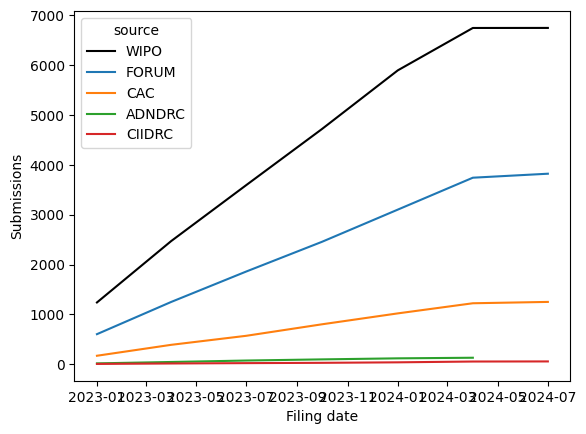

In [3]:
import seaborn as sns

outfile = '../data/Jan2023-Aug2024-parsed-proceedings.jsonl.gz'

genDf = pd.read_json(outfile, lines = True, convert_dates = ['submitted'])

genDf['quarter'] = genDf.submitted.dt.to_period('Q')
genDf['quarter_start'] = pd.PeriodIndex(genDf.quarter).to_timestamp()
dd = pd.concat([
    chunk.set_index("quarter_start")[['number']].cumsum().assign(source = source).reset_index() for source, chunk in genDf.groupby(['source', "quarter_start"]).agg({'number': 'nunique'}).reset_index().groupby('source')
])
ax = sns.lineplot(dd[dd.quarter_start <= "2024-07-01"], x = "quarter_start", y = 'number', hue = 'source', hue_order=['WIPO', 'FORUM', 'CAC', 'ADNDRC', 'CIIDRC'], palette=['black', 'tab:blue', 'tab:orange', 'tab:green', 'tab:red'])

ax.set_xlabel('Filing date')
ax.set_ylabel('Submissions')

In [4]:
genDf.columns

Index(['number', 'status', 'source', 'url', 'submitted', 'commenced',
       'panel_appointed', 'registrar_request_date', 'registrar_response_date',
       'published', 'registrars', 'panelists', 'registrant_default',
       'complainants', 'represented_by', 'complainants_countries',
       'respondents', 'respondents_countries', 'domains', 'trademarks',
       'quarter', 'quarter_start'],
      dtype='object')